# Machine Learning with Spark

In this lesson we'll take a look at how to implement and evaluate machine learning models with spark.

## Setup

First we'll do a couple of imports and setup our spark session

In [1]:
%matplotlib inline
import pyspark
import pyspark.ml
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder.getOrCreate()

We'll read in our csv file that contains our data. This is the same `swiss` dataset from `pydataset`, but with cleaned up column names.

In [2]:
swiss = spark.read.csv('swiss.csv', header=True, inferSchema=True)
swiss.show()

+---------+-----------+-----------+---------+--------+----------------+
|fertility|agriculture|examination|education|catholic|infant_mortality|
+---------+-----------+-----------+---------+--------+----------------+
|     80.2|       17.0|         15|       12|    9.96|            22.2|
|     83.1|       45.1|          6|        9|   84.84|            22.2|
|     92.5|       39.7|          5|        5|    93.4|            20.2|
|     85.8|       36.5|         12|        7|   33.77|            20.3|
|     76.9|       43.5|         17|       15|    5.16|            20.6|
|     76.1|       35.3|          9|        7|   90.57|            26.6|
|     83.8|       70.2|         16|        7|   92.85|            23.6|
|     92.4|       67.8|         14|        8|   97.16|            24.9|
|     82.4|       53.3|         12|        7|   97.67|            21.0|
|     82.9|       45.2|         16|       13|   91.38|            24.4|
|     87.1|       64.5|         14|        6|   98.61|          

## Classification

We'll first take a look at implementing a classification model. In order to do so, we'll need a categorical variable to predict. We'll transform the `catholic` column into a categorical variable indicating whether a province is catholic or not.

First we'll plot a histogram to justify why this transformation is reasonable to make:  

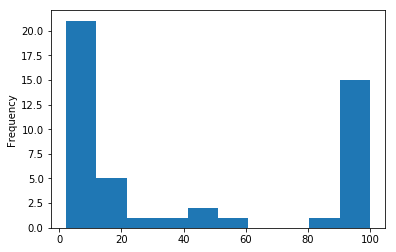

In [3]:
swiss.toPandas().catholic.plot.hist()

The visualization above tells us that most provinces fall into on of two extremes in regards to percentage catholic.

We'll now go ahead and use spark to make the transformation.

In [4]:
swiss = (swiss
 .withColumn('is_catholic', when(swiss.catholic > 60, 'Catholic').otherwise('Not Catholic'))
 .drop('catholic'))

In [5]:
swiss.show()

+---------+-----------+-----------+---------+----------------+------------+
|fertility|agriculture|examination|education|infant_mortality| is_catholic|
+---------+-----------+-----------+---------+----------------+------------+
|     80.2|       17.0|         15|       12|            22.2|Not Catholic|
|     83.1|       45.1|          6|        9|            22.2|    Catholic|
|     92.5|       39.7|          5|        5|            20.2|    Catholic|
|     85.8|       36.5|         12|        7|            20.3|Not Catholic|
|     76.9|       43.5|         17|       15|            20.6|Not Catholic|
|     76.1|       35.3|          9|        7|            26.6|    Catholic|
|     83.8|       70.2|         16|        7|            23.6|    Catholic|
|     92.4|       67.8|         14|        8|            24.9|    Catholic|
|     82.4|       53.3|         12|        7|            21.0|    Catholic|
|     82.9|       45.2|         16|       13|            24.4|    Catholic|
|     87.1| 

### Reshaping Our Data For Machine Learning

Spark's machine learning library requires that our data be in a very specific format. A dataframe that will be used with one of spark's machine learning models must have one column (`features`) that contains a list of the independent variable values, and another column (`label`) that contains the target variable. In addition, all numbers must be floats.

Luckily, spark supplies us with some functionality to make this transformation pretty easy.

Within the `pyspark.ml.feature` module are many classes that perform different transformations on dataframes, for example, min-max scaling. We'll take a look at the `RFormula` class, which we can use to quickly transform our data into the necessary format.

In [6]:
from pyspark.ml.feature import RFormula

rf = RFormula(formula='is_catholic ~ agriculture + examination')

df = rf.fit(swiss).transform(swiss).select('features', 'label')

Here we specified a string containing a formula that describes a linear model to be fit. This formula is taken from the R programming langauge. Here are several examples:

- `y ~ x`: predict `y` based on `x`
- `y ~ x1 + x2 + x3`: predict `y` based on `x1`, `x2`, and `x3`
- `y ~ .`: predict `y` based on all of the variables except for the independent variable (i.e. everything except for `y`)

In our case, we wrote a formula to predict `is_catholic` based on `agriculture` and `examination`.

The `RFormula` object will add two new columns to our data frame, `features`, and `label`, and we'll store those in `df` so that we can feed them into a Logistic Regression model.

In [7]:
df.show(5)

+-----------+-----+
|   features|label|
+-----------+-----+
|[17.0,15.0]|  0.0|
| [45.1,6.0]|  1.0|
| [39.7,5.0]|  1.0|
|[36.5,12.0]|  0.0|
|[43.5,17.0]|  0.0|
+-----------+-----+
only showing top 5 rows



In [8]:
from pyspark.ml.classification import LogisticRegression

Once we've imported the `LogisticRegression` class, we can make an instance of it, and use the `.fit` method to get a fitted model.

In [9]:
lr = LogisticRegression()
lr_fit = lr.fit(df)
lr_fit

LogisticRegressionModel: uid = LogisticRegression_34e96d850f81, numClasses = 2, numFeatures = 2

The `.transform` method can be used to make predictions with our model. The data we give to the `.transform` method needs to be in the same shape that we used for training the model.

We'll also add a column named `we_got_it_right`, which is boolean value that indicates whether or not our prediction was correct.

In [10]:
(lr_fit.transform(df)
 .withColumn('we_got_it_right', col('label') == col('prediction'))).show()

+-----------+-----+--------------------+--------------------+----------+---------------+
|   features|label|       rawPrediction|         probability|prediction|we_got_it_right|
+-----------+-----+--------------------+--------------------+----------+---------------+
|[17.0,15.0]|  0.0|[2.61081360006245...|[0.93155429036120...|       0.0|           true|
| [45.1,6.0]|  1.0|[-1.9844861732885...|[0.12084142107894...|       1.0|           true|
| [39.7,5.0]|  1.0|[-2.1417946363626...|[0.10510047647313...|       1.0|           true|
|[36.5,12.0]|  0.0|[0.65897957038476...|[0.65903112585454...|       0.0|           true|
|[43.5,17.0]|  0.0|[2.27460235659845...|[0.90675166037879...|       0.0|           true|
| [35.3,9.0]|  1.0|[-0.4347561719699...|[0.39299117537033...|       1.0|           true|
|[70.2,16.0]|  1.0|[0.78661973782068...|[0.68710506231533...|       0.0|          false|
|[67.8,14.0]|  1.0|[0.12378901391833...|[0.53090779502300...|       0.0|          false|
|[53.3,12.0]|  1.0|[-

To evaluate our model's performance, we can take a look at the `summary` property of the fit model.

In [11]:
training_summary = lr_fit.summary

This summary contains many properties that are common classification metrics. For example, we could find the area under the ROC curve and the overall accuracy like this:

In [12]:
training_summary.areaUnderROC

0.9314516129032259

In [13]:
training_summary.accuracy

0.8723404255319149

## Regression

Building a regression model will follow the same pattern as building the classification model.

For this example, we'll try to predict `fertility` based on `education` and `examination`.

In [19]:
swiss.show()

+---------+-----------+-----------+---------+--------+----------------+
|fertility|agriculture|examination|education|catholic|infant_mortality|
+---------+-----------+-----------+---------+--------+----------------+
|     80.2|       17.0|         15|       12|    9.96|            22.2|
|     83.1|       45.1|          6|        9|   84.84|            22.2|
|     92.5|       39.7|          5|        5|    93.4|            20.2|
|     85.8|       36.5|         12|        7|   33.77|            20.3|
|     76.9|       43.5|         17|       15|    5.16|            20.6|
|     76.1|       35.3|          9|        7|   90.57|            26.6|
|     83.8|       70.2|         16|        7|   92.85|            23.6|
|     92.4|       67.8|         14|        8|   97.16|            24.9|
|     82.4|       53.3|         12|        7|   97.67|            21.0|
|     82.9|       45.2|         16|       13|   91.38|            24.4|
|     87.1|       64.5|         14|        6|   98.61|          

Like before, we'll use the `RFormula` object to transform our data:

In [18]:
rf = RFormula(formula='fertility ~ education + examination')

df = (rf.fit(swiss)
 .transform(swiss)
 .select('features', 'label'))

df.show(5)

+-----------+-----+
|   features|label|
+-----------+-----+
|[12.0,15.0]| 80.2|
|  [9.0,6.0]| 83.1|
|  [5.0,5.0]| 92.5|
| [7.0,12.0]| 85.8|
|[15.0,17.0]| 76.9|
+-----------+-----+
only showing top 5 rows



And then feed the data into a spark machine learning model:

In [16]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
lr_fit = lr.fit(df)
lr_fit.transform(df).show()

+------------+-----+-----------------+
|    features|label|       prediction|
+------------+-----+-----------------+
| [9.96,15.0]| 80.2|70.15912634852639|
| [84.84,6.0]| 83.1|81.26429130386857|
|  [93.4,5.0]| 92.5|82.50822893852232|
|[33.77,12.0]| 85.8| 73.8127855836299|
| [5.16,17.0]| 76.9|68.18614583875217|
| [90.57,9.0]| 76.1|78.84520927628235|
|[92.85,16.0]| 83.8|72.73719567485625|
|[97.16,14.0]| 92.4|74.68969741578539|
|[97.67,12.0]| 82.4|76.48338421465071|
|[91.38,16.0]| 82.9|72.67575936832102|
|[98.61,14.0]| 87.1|74.75029785420449|
| [8.52,21.0]| 64.1|64.78182735845301|
| [2.27,14.0]| 66.9| 70.7239211388282|
| [4.43,19.0]| 68.9|66.38326449060946|
| [2.82,22.0]| 61.7| 63.6574188644052|
| [24.2,18.0]| 68.3|68.09570620435153|
|  [3.3,17.0]| 71.7| 68.1084101039525|
|[12.11,26.0]| 55.7|60.50093528053725|
| [2.15,31.0]| 54.3| 55.6537425539465|
| [2.84,19.0]| 65.1| 66.3168129753775|
+------------+-----+-----------------+
only showing top 20 rows



Like the logistic regression model, we have access to a `summary` property that gives us common regression model evaluation metrics.

In [17]:
training_summary = lr_fit.summary
training_summary.r2, training_summary.rootMeanSquaredError

(0.43024705652222606, 9.328132841820988)